In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

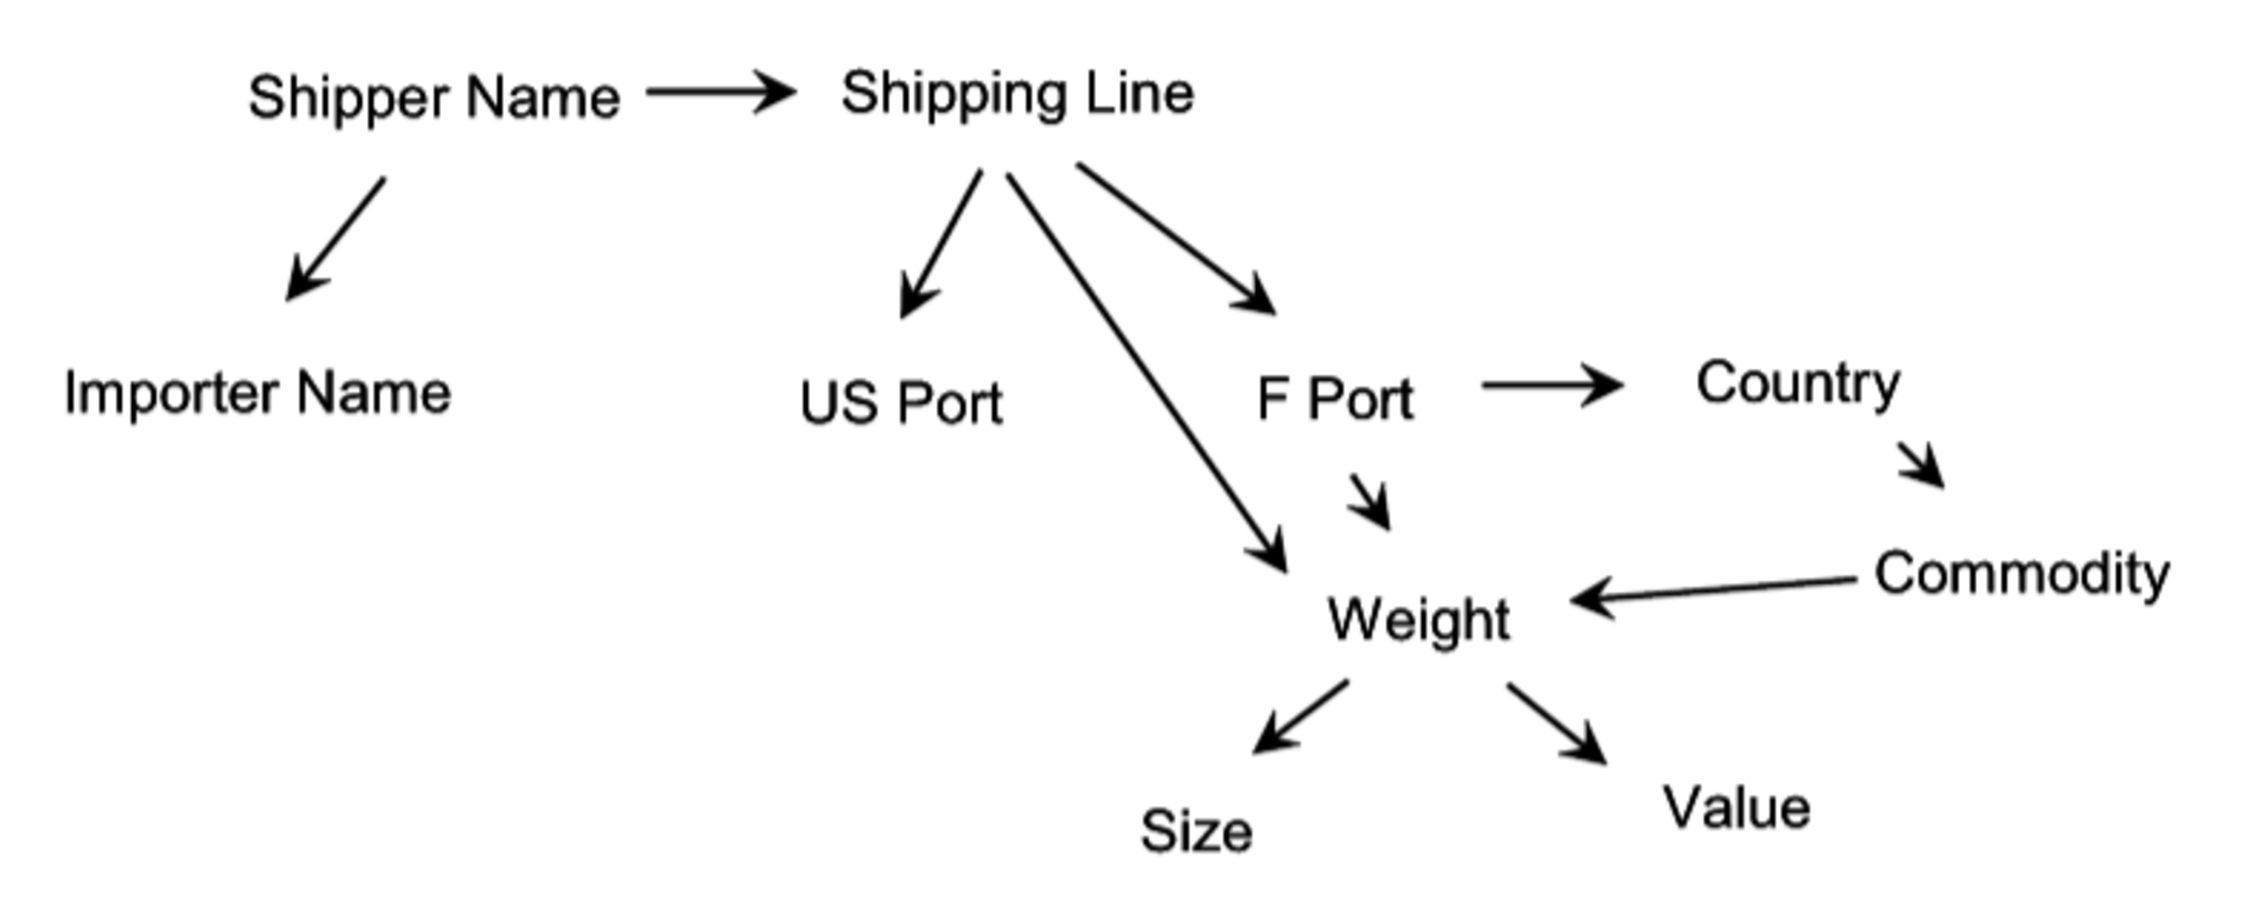

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)?

CI (Shipper Name, Value | Shipping Line)? 

CI (Foreign Port, Commodity | Country)? 

CI (Foreign Port, Commodity | County, Weight)? 

CI (Shipper Name, Value | F Port)?---Yes, independent.

CI (Shipper Name, Value | Shipping Line)?---Yes, independent.

CI (Foreign Port, Commodity | Country)?---Yes, independent.

CI (Foreign Port, Commodity | County, Weight)?---Yes, independent.

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

#### a) A heavy package shipped from Vancouver to Seattle by ASCO

#### b) A heavy package shipped from Vancouver to Seattle by CSCO

#### c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations)

In [3]:
# a) Pr(Heavy, ASCO, Vancouver, Seattle)
Pr_ASCO = 0.3
Pr_fport_V_ASCO = 1
Pr_USport_S_ASCO = 1
Pr_Heavy_V_ASCO = 15/100
PrA = Pr_ASCO*Pr_fport_V_ASCO*Pr_USport_S_ASCO*Pr_Heavy_V_ASCO
print("PrA =", PrA)
# b) Pr(Heavy, CSCO, Vancouver, Seattle)
Pr_CSCO = 70/100
Pr_fport_V_CSCO = 60/100
Pr_USport_S_CSCO = 80/100
Pr_Heavy_V_CSCO = 20/100
PrB = Pr_CSCO*Pr_fport_V_CSCO*Pr_USport_S_CSCO*Pr_Heavy_V_CSCO
print("PrB =", PrB)
# c) Pr(Heavy, Yokohama, Los Angeles, CSCO)
Pr_CSCO = 70/100
Pr_fport_Y_CSCO = 40/100
Pr_USport_L_CSCO = 20/100
Pr_Heavy_Y_CSCO = 60/100
PrC = Pr_CSCO*Pr_fport_Y_CSCO*Pr_USport_L_CSCO*Pr_Heavy_Y_CSCO
print("PrC =", PrC)
min(PrA, PrB, PrC)

PrA = 0.045
PrB = 0.06720000000000001
PrC = 0.0336


0.0336

So, A heavy package shipped from Yokohama to Los Angeles by CSCO is most anomalous.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [4]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points) 

In [5]:
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch

In [6]:
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = BayesianModel(hc.estimate().edges()) # convert DAG to BayesianModel
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('E', 'A')]


b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

In [7]:
from pgmpy.estimators import BayesianEstimator

In [8]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+--------+
| B(0) | 0.5015 |
+------+--------+
| B(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----

In [9]:
print(best_model.nodes())
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

['B', 'A', 'D', 'E']
(B _|_ D, E)

(D _|_ B, E)
(E _|_ B, D)


c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)

In [10]:
train_x = train.loc[:,['B','D','E']]
predicted_train = best_model.predict(train_x)
print("In sample:",(train.loc[:,'A'].reset_index(drop=True)==predicted_train['A']).mean())

test_x = test.loc[:,['B','D','E']]
predicted_test = best_model.predict(test_x)
print("Out of sample:",(test.loc[:,'A'].reset_index(drop=True)==predicted_test['A']).mean())

100%|██████████| 8/8 [00:00<00:00, 2258.65it/s]

In sample: 0.5766666666666667
Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [11]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [12]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [13]:
hours = data3.loc[:,'hour_0':'hour_23']
hours.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.055556,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.055342,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.045000,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.029412,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235


In [14]:
from sklearn.cluster import KMeans
km = KMeans(random_state=234,n_clusters=3)
res=km.fit(hours)
hours['label'] = res.labels_
hours.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323,2
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444,2
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042,2
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000,2
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235,2


#### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [15]:
hours.groupby(['label']).mean()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
label,,,,,,,,,,,,,,,,,,,,,
0,0.023882,0.014225,0.007948,0.003557,0.002436,0.000900,0.003289,0.008785,0.011896,0.025273,...,0.060039,0.045512,0.040215,0.045446,0.075694,0.108228,0.087384,0.075289,0.062395,0.036424
1,0.042486,0.012484,0.010632,0.009173,0.009353,0.007823,0.013453,0.023746,0.050991,0.092355,...,0.063096,0.068246,0.062162,0.052158,0.049157,0.041648,0.034145,0.024767,0.021921,0.018831
2,0.053421,0.041274,0.037163,0.031093,0.024575,0.018507,0.019218,0.023844,0.027299,0.032895,...,0.041788,0.046879,0.051019,0.053537,0.057246,0.057001,0.059598,0.056272,0.059585,0.052486


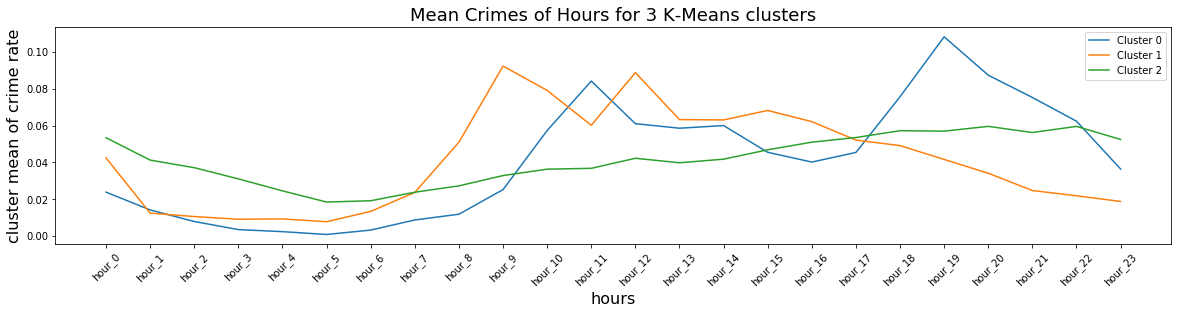

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(hours.groupby(['label']).mean().iloc[0],label='Cluster 0')
plt.plot(hours.groupby(['label']).mean().iloc[1],label='Cluster 1')
plt.plot(hours.groupby(['label']).mean().iloc[2],label='Cluster 2')
plt.legend()
plt.title('Mean Crimes of Hours for 3 K-Means clusters', fontsize=18)
plt.xlabel('hours',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.xticks(rotation=45)
plt.show()

#### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

From hour0 to hour7, all the crimes are lower than other time periods.

For cluster 0, crimes can achieve peak at night (hour19-hour20), also at noon(hour11-hour12).

For cluster 1, there are a lot of crimes happened in the morning.

For cluster 2, the trend is very gentle, no significant peak.

#### c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [17]:
data3['label'] = res.labels_
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,2
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,2
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,2
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,2
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,2


In [18]:
print('Cluster0:')
list(data3[data3['label']==0]['crime_type'])

Cluster0:


['DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT',
 'GAMBLING: GAME/DICE',
 'INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING IDENTIFICATION',
 'NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS',
 'NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS',
 'NARCOTICS: MANU/DELIVER: HEROIN (WHITE)',
 'NARCOTICS: MANU/DELIVER:CRACK',
 'NARCOTICS: POSS: CANNABIS 30GMS OR LESS',
 'NARCOTICS: POSS: CANNABIS MORE THAN 30GMS',
 'NARCOTICS: POSS: CRACK',
 'NARCOTICS: POSS: HEROIN(WHITE)',
 'NARCOTICS: POSS: PCP',
 'NARCOTICS: POSS: SYNTHETIC DRUGS',
 'NARCOTICS: POSSESSION OF DRUG EQUIPMENT',
 'NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY',
 'OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION',
 'OTHER OFFENSE: GUN OFFENDER: DUTY TO REGISTER',
 'OTHER OFFENSE: LICENSE VIOLATION',
 'OTHER OFFENSE: PAROLE VIOLATION',
 'OTHER OFFENSE: SEX OFFENDER: FAIL TO REGISTER',
 'PUBLIC PEACE VIOLATION: RECKLESS CONDUCT']

###### In cluster 1, most are narcotics and other offense.

In [19]:
print('Cluster1:')
list(data3[data3['label']==1]['crime_type'])

Cluster1:


['ASSAULT: PRO EMP HANDS NO/MIN INJURY',
 'BATTERY: PRO EMP HANDS NO/MIN INJURY',
 'BURGLARY: UNLAWFUL ENTRY',
 'DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTITY THEFT',
 'DECEPTIVE PRACTICE: BOGUS CHECK',
 'DECEPTIVE PRACTICE: COUNTERFEIT CHECK',
 'DECEPTIVE PRACTICE: CREDIT CARD FRAUD',
 'DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $300 AND UNDER',
 'DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT OVER $ 300',
 'DECEPTIVE PRACTICE: FORGERY',
 'DECEPTIVE PRACTICE: FRAUD OR CONFIDENCE GAME',
 'DECEPTIVE PRACTICE: ILLEGAL USE CASH CARD',
 'NARCOTICS: FOUND SUSPECT NARCOTICS',
 'OFFENSE INVOLVING CHILDREN: CHILD ABDUCTION',
 'OFFENSE INVOLVING CHILDREN: OTHER OFFENSE',
 'OTHER OFFENSE: ANIMAL ABUSE/NEGLECT',
 'OTHER OFFENSE: HARASSMENT BY ELECTRONIC MEANS',
 'OTHER OFFENSE: HARASSMENT BY TELEPHONE',
 'OTHER OFFENSE: OTHER CRIME AGAINST PERSON',
 'OTHER OFFENSE: OTHER CRIME INVOLVING PROPERTY',
 'OTHER OFFENSE: SEX OFFENDER: FAIL REG NEW ADD',
 'OTHER OFFENSE: TELEPHONE THREAT',
 'PUBLIC PE

##### In cluster 2, DECEPTIVE PRACTICE is the domain crime .

In [20]:
print('Cluster2:')
list(data3[data3['label']==2]['crime_type'])

Cluster2:


['ARSON: BY FIRE',
 'ASSAULT: AGG PO HANDS NO/MIN INJURY',
 'ASSAULT: AGGRAVATED: HANDGUN',
 'ASSAULT: AGGRAVATED: OTHER DANG WEAPON',
 'ASSAULT: AGGRAVATED: OTHER FIREARM',
 'ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR',
 'ASSAULT: SIMPLE',
 'BATTERY: AGG PO HANDS NO/MIN INJURY',
 'BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY',
 'BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY',
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY',
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST',
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON',
 'BATTERY: AGGRAVATED OF A SENIOR CITIZEN',
 'BATTERY: AGGRAVATED: HANDGUN',
 'BATTERY: AGGRAVATED: OTHER DANG WEAPON',
 'BATTERY: AGGRAVATED:KNIFE/CUTTING INSTR',
 'BATTERY: DOMESTIC BATTERY SIMPLE',
 'BATTERY: SIMPLE',
 'BURGLARY: ATTEMPT FORCIBLE ENTRY',
 'BURGLARY: FORCIBLE ENTRY',
 'BURGLARY: HOME INVASION',
 'CRIM SEXUAL ASSAULT: AGGRAVATED: OTHER',
 'CRIM SEXUAL ASSAULT: NON-AGGRAVATED',
 'CRIMINAL DAMAGE: CRIMINAL DEF

##### Most assult, battery, robbery, criminal damage, criminal trespass and weapons violation are assigned to cluster 2.

#### d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)

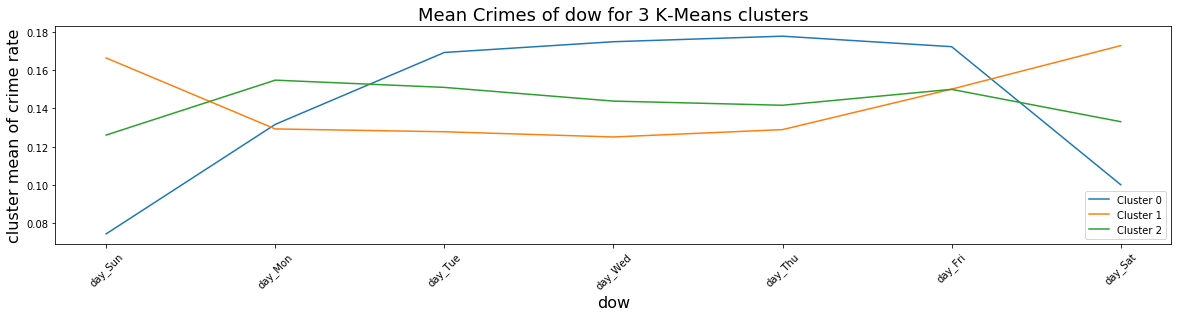

In [21]:
dow = data3.loc[:,'day_Sun':'day_Sat']
km = KMeans(random_state=234,n_clusters=3)
res=km.fit(dow)
dow['label'] = res.labels_
data3['dow_label'] = res.labels_
plt.figure(figsize=(20,4))
plt.plot(dow.groupby(['label']).mean().iloc[0],label='Cluster 0')
plt.plot(dow.groupby(['label']).mean().iloc[1],label='Cluster 1')
plt.plot(dow.groupby(['label']).mean().iloc[2],label='Cluster 2')
plt.legend()
plt.title('Mean Crimes of dow for 3 K-Means clusters', fontsize=18)
plt.xlabel('dow',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.xticks(rotation=45)
plt.show()

Crimes in cluster1 are higher in weekend, crimes in cluster0 and cluater2 are higher in weekdays.

#### e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [22]:
data3.head(3)
#The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label,dow_label
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,2,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,2,1
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,2,1


In [23]:
community = data3.iloc[:, -79:]
community_mean = community.groupby(['dow_label']).mean()
community_mean = community_mean.drop(['label'],axis=1)
community_mean.head()

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
dow_label,,,,,,,,,,,,,,,,,,,,,
0,0.012653,0.011230,0.014829,0.007060,0.007010,0.017283,0.011908,0.035317,0.001328,0.006129,...,0.021924,0.020917,0.006914,0.028308,0.005068,0.008919,0.002283,0.009041,0.009096,0.008680
1,0.012467,0.012436,0.012403,0.007165,0.003183,0.020669,0.009787,0.034590,0.000845,0.003535,...,0.025424,0.026819,0.009812,0.027926,0.002618,0.011326,0.001994,0.006977,0.004106,0.007121
2,0.013471,0.011394,0.013090,0.007141,0.004321,0.018526,0.010349,0.027620,0.000943,0.003840,...,0.028674,0.028343,0.007501,0.028972,0.002730,0.011461,0.001949,0.007705,0.010711,0.007310


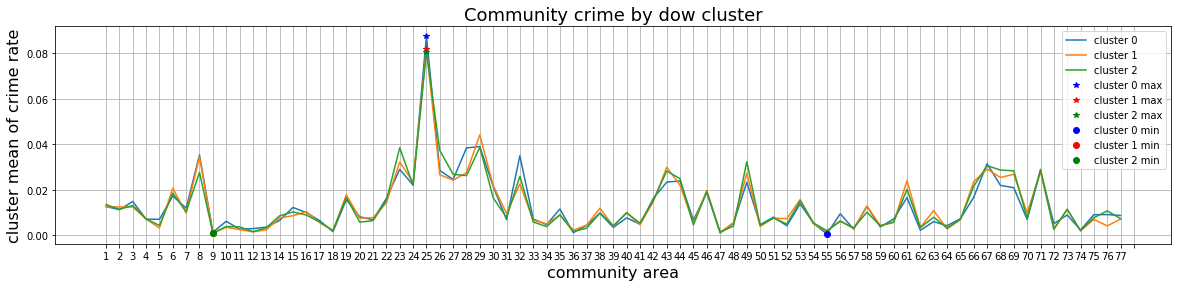

In [24]:
ax = plt.figure(figsize = (20,4))
plt.plot(community_mean.loc[0], label = 'cluster 0')
plt.plot(community_mean.loc[1], label = 'cluster 1')
plt.plot(community_mean.loc[2], label = 'cluster 2')
# max
max_c0 = plt.plot(community_mean.loc[0].idxmax(), max(community_mean.loc[0]), 'b*',label="cluster 0 max")
max_c1 = plt.plot(community_mean.loc[1].idxmax(), max(community_mean.loc[1]), 'r*', label="cluster 1 max")
max_c2 = plt.plot(community_mean.loc[2].idxmax(), max(community_mean.loc[2]), 'g*', label="cluster 2 max")
# min
min_c0 = plt.plot(community_mean.loc[0].idxmin(), min(community_mean.loc[0]), 'bo', label="cluster 0 min")
min_c1 = plt.plot(community_mean.loc[1].idxmin(), min(community_mean.loc[1]), 'ro', label="cluster 1 min")
min_c2 = plt.plot(community_mean.loc[2].idxmin(), min(community_mean.loc[2]), 'go', label="cluster 2 min")
plt.grid(b=True)
plt.legend(loc = 'upper right')
plt.title('Community crime by dow cluster', fontsize=18)
plt.xlabel('community area',fontsize=16)
plt.xticks(range(0,78),range(1,78))
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.show()

In [25]:
data4.head(3)

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330


In [26]:
# the largest in cluster0
community_mean.loc[0].nlargest(5)

community_area_25    0.087524
community_area_29    0.038996
community_area_28    0.038405
community_area_8     0.035317
community_area_32    0.034979
Name: 0, dtype: float64

In [27]:
data4.iloc[[25,29,28,8,32], 4:]

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
25,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
29,15.2,30.7,15.8,54.8,33.8,10402,14.103657,4460
28,7.4,43.1,21.2,27.6,42.7,12034,21.888178,8073
8,1.1,3.3,6.5,7.4,35.3,40959,4.794521,283
32,1.3,13.8,4.9,7.4,21.8,59077,16.022022,1773


In [28]:
# the largest in cluster1
community_mean.loc[1].nlargest(5)

community_area_25    0.082085
community_area_29    0.044130
community_area_8     0.034590
community_area_23    0.032179
community_area_43    0.029877
Name: 1, dtype: float64

In [29]:
data4.iloc[[25,29,8,23,43], 4:]

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
25,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
29,15.2,30.7,15.8,54.8,33.8,10402,14.103657,4460
8,1.1,3.3,6.5,7.4,35.3,40959,4.794521,283
23,2.3,14.7,6.6,12.9,21.7,43198,8.734616,7754
43,3.3,27.8,24.0,14.5,40.3,18881,16.298376,5879


In [30]:
# the largest in cluster2
community_mean.loc[2].nlargest(5)

community_area_25    0.080744
community_area_29    0.038681
community_area_23    0.038476
community_area_26    0.037284
community_area_49    0.032330
Name: 2, dtype: float64

In [31]:
data4.iloc[[25,29,23,26,49], 4:]

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
25,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
29,15.2,30.7,15.8,54.8,33.8,10402,14.103657,4460
23,2.3,14.7,6.6,12.9,21.7,43198,8.734616,7754
26,8.2,42.4,19.6,21.3,43.2,12961,19.899589,4727
49,1.5,21.6,22.8,13.1,38.6,20588,13.146233,1124


For all the communities above, the PERCENT AGED UNDER 18 OR OVER 64 is similar. Comunities with higher per capita income have less number of crimes. Communities have higher % of household below poverty, higher % of aged 16+ unemployed and higher % aged 25+ without high school diploma. So the poverty and education level could effect the crime rate of the neighborhood.

#### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)



In [32]:
fbi = data3[['Category','label']]
for i in range(0,3):
    print('for cluster %d' %i)
    print(fbi[fbi['label']==i].Category.value_counts())
    print(fbi[fbi['label']==i].Category.value_counts(normalize=True))
    print('\n')

for cluster 0
P2    21
Name: Category, dtype: int64
P2    1.0
Name: Category, dtype: float64


for cluster 1
P2     23
P1P     4
Name: Category, dtype: int64
P2     0.851852
P1P    0.148148
Name: Category, dtype: float64


for cluster 2
P2     36
P1V    24
P1P    11
Name: Category, dtype: int64
P2     0.507042
P1V    0.338028
P1P    0.154930
Name: Category, dtype: float64




Cluster 0 is all P2. Cluster 1 has P2 and P1P, is dominated by P2. Half of cluster 2 are P2, also include P1V and P1P.

#### g) For part g, you will use the same dataset to compare the clusters produced by several different methods. But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat). Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric. In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify). For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [33]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

In [34]:
dow = dow.drop(['label'],axis=1)
dow.head()

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
0,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972
1,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185
2,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776
3,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000
4,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275


#### (i) k-means

In [35]:
cluster_num = {}
for n_clusters in range(2,21):
    KM_g = KMeans(random_state=2019, n_clusters=n_clusters)
    pred = KM_g.fit_predict(dow)
    score = silhouette_score (dow, pred)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score

For n_clusters = 2, silhouette score is 0.2365303906851532)
For n_clusters = 3, silhouette score is 0.22307667421366)
For n_clusters = 4, silhouette score is 0.2323476722005907)
For n_clusters = 5, silhouette score is 0.2423663882484861)
For n_clusters = 6, silhouette score is 0.16207064584733222)
For n_clusters = 7, silhouette score is 0.1736691559496708)
For n_clusters = 8, silhouette score is 0.15213089076154562)
For n_clusters = 9, silhouette score is 0.1531793372159468)
For n_clusters = 10, silhouette score is 0.1649556967346504)
For n_clusters = 11, silhouette score is 0.1666608912798734)
For n_clusters = 12, silhouette score is 0.16607197040978028)
For n_clusters = 13, silhouette score is 0.16490595288944837)
For n_clusters = 14, silhouette score is 0.14578489758916238)
For n_clusters = 15, silhouette score is 0.15510715753320367)
For n_clusters = 16, silhouette score is 0.1557390447371024)
For n_clusters = 17, silhouette score is 0.1517343221883554)
For n_clusters = 18, silhoue

In [37]:
KM_g_best= KMeans(n_clusters = 5, random_state= 2019)
res_g = KM_g_best.fit(dow)
kmeans_data = dow.copy()
kmeans_data['kmeans_label'] = res_g.labels_
print ("\n The best cluster number for k-means is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (kmeans_data['kmeans_label'].value_counts())


 The best cluster number for k-means is: 5, distribution of each category is: 
3    58
0    44
4     9
1     6
2     2
Name: kmeans_label, dtype: int64


#### (ii) Gaussian mixture models

In [38]:
cluster_num = {}
for n_clusters in range(2,21):
    GM_g= GaussianMixture(random_state=2019, n_components=n_clusters)
    pred = GM_g.fit_predict(dow)
    score = silhouette_score (dow, pred)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score

For n_clusters = 2, silhouette score is 0.2946566408627777)
For n_clusters = 3, silhouette score is 0.22013831871903825)
For n_clusters = 4, silhouette score is 0.19075916535263895)
For n_clusters = 5, silhouette score is 0.1615701405917098)
For n_clusters = 6, silhouette score is 0.13139323455735424)
For n_clusters = 7, silhouette score is 0.13634186980063065)
For n_clusters = 8, silhouette score is 0.08870231438958817)
For n_clusters = 9, silhouette score is 0.11826760151490419)
For n_clusters = 10, silhouette score is 0.11866097303636317)
For n_clusters = 11, silhouette score is 0.1642746727751976)
For n_clusters = 12, silhouette score is 0.16518311917149797)
For n_clusters = 13, silhouette score is 0.1241697683986825)
For n_clusters = 14, silhouette score is 0.10350459547339179)
For n_clusters = 15, silhouette score is 0.12230004660882114)
For n_clusters = 16, silhouette score is 0.1130295651855168)
For n_clusters = 17, silhouette score is 0.10273939666007675)
For n_clusters = 18, 

In [39]:
gmm = GaussianMixture(random_state=2019, n_components=2)
fit_gmm = gmm.fit_predict(dow)
gmm_data = dow.copy()
gmm_data['gmm_lable'] = fit_gmm
print ("\n The cluster number for Gaussian Mixture is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (gmm_data['gmm_lable'].value_counts())


 The cluster number for Gaussian Mixture is: 2, distribution of each category is: 
0    93
1    26
Name: gmm_lable, dtype: int64


#### (iii) Bottom-up hierarchical clustering with "single link" distance metric

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
cluster_num = {}
range_n_clusters = range(2,21)
Z = linkage(dow, 'single')
for n_clusters in range_n_clusters:
    single_labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(dow, single_labels)
    print("For n_clusters ={},".format(n_clusters)+" the silhouette score is :{}".format(score))
    cluster_num[n_clusters] = score

For n_clusters =2, the silhouette score is :0.6377648080667613
For n_clusters =3, the silhouette score is :0.5568477382969328
For n_clusters =4, the silhouette score is :0.40557775075981567
For n_clusters =5, the silhouette score is :0.38770381887486705
For n_clusters =6, the silhouette score is :0.3900761951022192
For n_clusters =7, the silhouette score is :0.3462184482039438
For n_clusters =8, the silhouette score is :0.32899815764355905
For n_clusters =9, the silhouette score is :0.32542192748924165
For n_clusters =10, the silhouette score is :0.3132151039050357
For n_clusters =11, the silhouette score is :0.21831462782301697
For n_clusters =12, the silhouette score is :0.15913660974826932
For n_clusters =13, the silhouette score is :0.08885073202230036
For n_clusters =14, the silhouette score is :0.03419294806094897
For n_clusters =15, the silhouette score is :0.04440663336747251
For n_clusters =16, the silhouette score is :0.038018460768224766
For n_clusters =17, the silhouette sc

In [41]:
single_label=fcluster(Z, 2, criterion='maxclust') 
single_data=dow.copy()
single_data['single_label'] = single_label
print ("\n The cluster number for Single link is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (single_data['single_label'].value_counts())


 The cluster number for Single link is: 2, distribution of each category is: 
1    118
2      1
Name: single_label, dtype: int64


#### (iv) Bottom-up hierarchical clustering with "complete link" distance metric

In [42]:
cluster_num = {}
range_n_clusters = range(2,21)
Z = linkage(dow, 'complete')
for n_clusters in range_n_clusters:
    complete_labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(dow, complete_labels)
    print("For n_clusters ={},".format(n_clusters)+" the silhouette score is :{}".format(score))
    cluster_num[n_clusters] = score

For n_clusters =2, the silhouette score is :0.6100646113547021
For n_clusters =3, the silhouette score is :0.17268718146566117
For n_clusters =4, the silhouette score is :0.19215169374768618
For n_clusters =5, the silhouette score is :0.15025207822499773
For n_clusters =6, the silhouette score is :0.15229681572228093
For n_clusters =7, the silhouette score is :0.14926267616109448
For n_clusters =8, the silhouette score is :0.10130440123428043
For n_clusters =9, the silhouette score is :0.10066503899164778
For n_clusters =10, the silhouette score is :0.1106113243154708
For n_clusters =11, the silhouette score is :0.1253714185643158
For n_clusters =12, the silhouette score is :0.11418383303622578
For n_clusters =13, the silhouette score is :0.11216165708562796
For n_clusters =14, the silhouette score is :0.10909628423478156
For n_clusters =15, the silhouette score is :0.1139450721711721
For n_clusters =16, the silhouette score is :0.12172790149957843
For n_clusters =17, the silhouette sc

In [43]:
complete_label=fcluster(Z, 2, criterion='maxclust') 
complete_data=dow.copy()
complete_data['complete_label'] = complete_label
print ("\n The cluster number for Single link is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (complete_data['complete_label'].value_counts())


 The cluster number for Single link is: 2, distribution of each category is: 
2    117
1      2
Name: complete_label, dtype: int64
